In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, AutoModelForSequenceClassification
import torch

from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

/home/lb4489/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "/scratch/lb4489/LLM"

# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", cache_dir=model_path, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", cache_dir=model_path, trust_remote_code=True)

In [3]:
num_labels_promoter = 2
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", num_labels=num_labels_promoter, cache_dir=model_path)

device = torch.device("cuda")
model = model.to(device)

The repository for InstaDeepAI/nucleotide-transformer-v2-500m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y
The repository for InstaDeepAI/nucleotide-transformer-v2-500m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [4]:
import pandas as pd

file_path = "/scratch/lb4489/LLM/Coding_NonCoding_DNA_Sequences"  
df = pd.read_csv(file_path, sep=",", header=0) 
df_selected = df.iloc[:, [2, 3]]
print(df_selected.head())

                                        DNA_sequence  Target
0  CTCTTGCGGTCGATCTGGTCACGGGTGATGGTGAAGGTTACGTAGT...       1
1  TCGCGGTCCCGAGCCTGATCGTGCGCCGCGCCAACACGACGGTCGA...       1
2  GGCTACGACGTGACCGCGGGGCAGGTGCTCGTGACCAACGGCGGCA...       1
3  CAGGTAGGTGCCACAGTAGTAAGCGGTGATGCAGTTGCCCCTGAAT...       1
4  GAGTTGTCCTGGTAAGATTCTTACCCATGCGAATCACGTCGAAAGG...       1


In [5]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset

In [6]:
df_selected.columns = ["data", "labels"]  
df_selected["labels"] = df_selected["labels"].astype(int)

train_data, val_data, train_labels, val_labels = train_test_split(
    df_selected["data"], df_selected["labels"], test_size=0.2, random_state=42
)

ds_train = Dataset.from_dict({"data": train_data.tolist(), "labels": train_labels.tolist()})
ds_validation = Dataset.from_dict({"data": val_data.tolist(), "labels": val_labels.tolist()})

print(ds_train)
print(ds_validation)

Dataset({
    features: ['data', 'labels'],
    num_rows: 52256
})
Dataset({
    features: ['data', 'labels'],
    num_rows: 13065
})


/tmpdata/ipykernel_2349793/2918007003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["labels"] = df_selected["labels"].astype(int)


In [7]:
print(type(ds_train[0]["labels"]))

<class 'int'>


In [8]:
def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs

In [9]:
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map: 100%|██████████| 13065/13065 [00:02<00:00, 5167.04 examples/s]


In [10]:
from transformers import TrainingArguments, Trainer

In [26]:
batch_size = 16
model_name='nucleotide-transformer'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 2000,
    weight_decay=0.01,  #gpt给的三个参数还挺重要的，能让表现提升
    lr_scheduler_type="linear", 
    warmup_ratio=0.1,
)

/home/lb4489/.local/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 计算 Accuracy, F1-score, Recall
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "f1_score": f1
    }



In [28]:
trainer = Trainer(
    model.to(device),
    args=args_promoter,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # 使用新的 metrics 计算函数
)

/tmpdata/ipykernel_2349793/1959967892.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [29]:
trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,0.505000,0.544393,0.722733,0.696970
200,0.473300,0.592035,0.714537,0.694253
300,0.506500,0.586823,0.702436,0.697631
400,0.455500,0.621877,0.704121,0.688750
500,0.504800,0.580768,0.703202,0.697001
600,0.499900,0.562968,0.710401,0.708106
700,0.529000,0.542022,0.729856,0.702534
800,0.529200,0.543633,0.728860,0.702575
900,0.495800,0.579127,0.722580,0.656381
1000,0.533700,0.530682,0.736749,0.718227


Could not locate the best model at nucleotide-transformer-finetuned-NucleotideTransformer/checkpoint-1300/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


{'eval_loss': 0.5181562304496765,
 'eval_accuracy': 0.7411151960784313,
 'eval_f1_score': 0.7149100585385345,
 'eval_runtime': 52.7085,
 'eval_samples_per_second': 247.873,
 'eval_steps_per_second': 3.889,
 'epoch': 0.612369871402327}

In [30]:

curve_evaluation_f1_score = [[a['step'], a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a]

curve_evaluation_accuracy = [[a['step'], a['eval_accuracy']] for a in trainer.state.log_history if 'eval_accuracy' in a]


eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
eval_accuracy = [c[1] for c in curve_evaluation_accuracy]

steps = [c[0] for c in curve_evaluation_f1_score] 

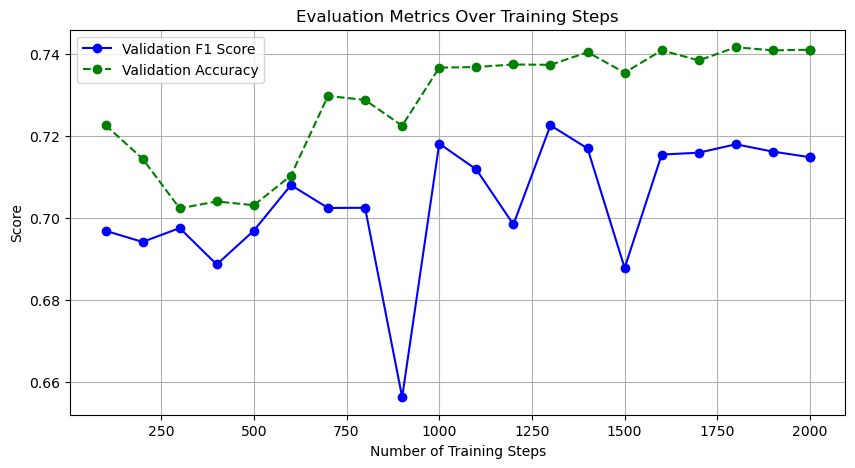

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(steps, eval_f1_score, 'b', marker="o", linestyle="-", label='Validation F1 Score')

plt.plot(steps, eval_accuracy, 'g', marker="o", linestyle="--", label='Validation Accuracy')

plt.title('Evaluation Metrics Over Training Steps')
plt.xlabel('Number of Training Steps')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
#感觉还行，继续训练或许还能涨，已经比kaggle两个模型表现好多了，而且还要考虑到这个来历不明的数据也不一定多准确

In [33]:
import pandas as pd

# 读取 TSV 文件
df = pd.read_csv("/scratch/lb4489/LLM/valid.tsv", sep="\t")

# 显示前几行
print(df.head())


   chrom     start       end strand  label  \
0      5  10798867  10799378      +      0   
1      5     79484     79995      +      0   
2      5    713949    714460      -      0   
3      5   5526039   5526550      -      1   
4      5  16826521  16827032      -      0   

                                           sequences  
0  GTAAGGGATTTTACTCACTCTTGAGCACTCAAGATAAATTCCAAGA...  
1  CTTGTATGCAAAGGTTTGGATCCCTCTTCTCTTGCTTTTATATGTA...  
2  CTGAAATCATTGACTTTTTTCGGAGATAAACCCAAAAGGTTCCTTA...  
3  ATACCTGAACAAAATCAAATGCTTTGATAAGACACTTCCAAAAAAC...  
4  ACACTGGAAACGCCGGCCATTCGGTTGGAATCGGTGAATTGGTGAA...  


In [34]:
df_selected = df.iloc[:, [5,4]]
print(df_selected.head())

                                           sequences  label
0  GTAAGGGATTTTACTCACTCTTGAGCACTCAAGATAAATTCCAAGA...      0
1  CTTGTATGCAAAGGTTTGGATCCCTCTTCTCTTGCTTTTATATGTA...      0
2  CTGAAATCATTGACTTTTTTCGGAGATAAACCCAAAAGGTTCCTTA...      0
3  ATACCTGAACAAAATCAAATGCTTTGATAAGACACTTCCAAAAAAC...      1
4  ACACTGGAAACGCCGGCCATTCGGTTGGAATCGGTGAATTGGTGAA...      0


In [35]:
df_selected.shape[0]

57825

In [36]:
print(df_selected["label"].value_counts())


label
0    50514
1     7311
Name: count, dtype: int64


In [37]:
df_selected.columns = ["data", "labels"]  
df_selected["labels"] = df_selected["labels"].astype(int)

train_data, val_data, train_labels, val_labels = train_test_split(
    df_selected["data"], df_selected["labels"], test_size=0.2, random_state=42
)

ds_train = Dataset.from_dict({"data": train_data.tolist(), "labels": train_labels.tolist()})
ds_validation = Dataset.from_dict({"data": val_data.tolist(), "labels": val_labels.tolist()})

print(ds_train)
print(ds_validation)

Dataset({
    features: ['data', 'labels'],
    num_rows: 46260
})
Dataset({
    features: ['data', 'labels'],
    num_rows: 11565
})


/tmpdata/ipykernel_2349793/2918007003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["labels"] = df_selected["labels"].astype(int)


In [38]:
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map: 100%|██████████| 11565/11565 [00:06<00:00, 1833.21 examples/s]


In [39]:
batch_size = 16
model_name='nucleotide-transformer'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 2000,
    weight_decay=0.01,  #gpt给的三个参数还挺重要的，能让表现提升
    lr_scheduler_type="linear", 
    warmup_ratio=0.1,
)

/home/lb4489/.local/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
trainer = Trainer(
    model.to(device),
    args=args_promoter,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # 使用新的 metrics 计算函数
)

/tmpdata/ipykernel_2349793/1959967892.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [41]:
trainer.train() #我重置模型了吗？看起来表现要比上一个数据集好多了
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,0.382500,0.370749,0.872917,0.814183
200,0.310200,0.280912,0.889062,0.862444
300,0.284100,0.276101,0.904167,0.890434
400,0.252600,0.249065,0.915451,0.903751
500,0.234800,0.229222,0.906597,0.908355
600,0.238700,0.203822,0.926736,0.922120


KeyboardInterrupt: 

In [ ]:
curve_evaluation_f1_score = [[a['step'], a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a]

curve_evaluation_accuracy = [[a['step'], a['eval_accuracy']] for a in trainer.state.log_history if 'eval_accuracy' in a]


eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
eval_accuracy = [c[1] for c in curve_evaluation_accuracy]

steps = [c[0] for c in curve_evaluation_f1_score] 

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(steps, eval_f1_score, 'b', marker="o", linestyle="-", label='Validation F1 Score')

plt.plot(steps, eval_accuracy, 'g', marker="o", linestyle="--", label='Validation Accuracy')

plt.title('Evaluation Metrics Over Training Steps')
plt.xlabel('Number of Training Steps')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.show()